In [1]:
import xarray as xr
import pandas as pd
import salem

In [2]:
import _pickle as cpickle

In [3]:
import sys
sys.path.append('../scripts/')
sys.path.append("/home/abhi/Documents/mygit/postBC_diagnostic/src/scripts")
from recipes import *

In [4]:
from Model import *


In [5]:
def retrieveFile(model, variable, scen, metric, **kwargs):
    m = NEXModel.from_details(model, variable, scen)
    m.outdir = '/media/abhi/My_Passport/NEX-GDDP-NASA-PROCESSED'
    return(m.retrieve(metric=metric, **kwargs))

In [10]:
variables = ['pr', 'tas', 'tasmax', 'tasmin']
scens = ['historical', 'rcp45', 'rcp85']

In [11]:
model = 'EnsMean_ALL21'

In [23]:
dset_dict = {scen:
    {variable: monmean(xr.open_dataset(retrieveFile(model, variable, 
                                                    scen, 'monmean'))[variable])
             for variable in variables}
    for scen in scens}

In [24]:
dset_dict

{'historical': {'pr': <xarray.DataArray 'pr' (time: 672, lat: 160, lon: 200)>
  array([[[3.097591e+00, 3.092750e+00, ..., 9.586568e+00, 9.923576e+00],
          [3.065760e+00, 3.063046e+00, ..., 9.875473e+00, 1.022005e+01],
          ...,
          [3.688348e-01, 3.688627e-01, ..., 0.000000e+00, 0.000000e+00],
          [3.537109e-01, 3.538214e-01, ..., 0.000000e+00, 0.000000e+00]],
  
         [[1.634471e+00, 1.648614e+00, ..., 7.192514e+00, 7.632273e+00],
          [1.617316e+00, 1.630041e+00, ..., 7.463056e+00, 7.903717e+00],
          ...,
          [4.352379e-01, 4.445819e-01, ..., 7.555135e-04, 1.037017e-03],
          [3.910366e-01, 3.933941e-01, ..., 1.268488e-04, 1.711856e-04]],
  
         ...,
  
         [[2.057776e+00, 2.068104e+00, ..., 1.176251e+01, 1.154272e+01],
          [2.054296e+00, 2.064389e+00, ..., 1.126736e+01, 1.103492e+01],
          ...,
          [2.947570e-01, 2.947761e-01, ..., 4.233273e-02, 4.628976e-02],
          [2.839076e-01, 2.833756e-01, ..., 3.660

In [21]:
variableIndex = pd.Index(variables, name='variable')

In [28]:
scen = 'rcp85'

In [29]:
ds = xr.concat(dset_dict[scen].values(), dim=variableIndex).to_dataset(name='value')

In [32]:
dsets = {scen : xr.concat(dset_dict[scen].values(), dim=variableIndex).to_dataset(name='value')
        for scen in scens}

In [34]:
scenIndex = pd.Index(['rcp45', 'rcp85'], name='scen')

In [36]:
dsets['future'] = xr.concat([dsets['rcp45'], dsets['rcp85']], dim=scenIndex)

In [40]:
change = dsets['future'].mean(dim='time') - dsets['historical'].mean(dim='time')

In [48]:
yearmean(dsets['historical'])

<xarray.Dataset>
Dimensions:   (lat: 160, lon: 200, variable: 4, year: 56)
Coordinates:
  * lon       (lon) float32 60.125 60.375 60.625 ... 109.375 109.625 109.875
  * lat       (lat) float32 0.125 0.375 0.625 0.875 ... 39.375 39.625 39.875
  * variable  (variable) object 'pr' 'tas' 'tasmax' 'tasmin'
  * year      (year) int64 1950 1951 1952 1953 1954 ... 2001 2002 2003 2004 2005
Data variables:
    value     (year, variable, lat, lon) float32 3.1003797 ... 1.4577662

In [122]:
def get_years(year_str):
    y1, y2 = list(map(lambda x : int(x), year_str.split('-')))
    return([y1, y2])

def conv_ds_to_seas_years(ds, seasons=['Annual', 'DJF', 'MAM', 'JJAS', 'ON']):
    seasIndex = pd.Index(seasons, name='seas')
    dsets = []
    for seas in seasons:
        if seas == 'Annual':
            dsets.append(yearmean(ds))
        else:
            dsets.append(yearmean(selseas(ds, seas)))
            
    seas_year_ds = xr.concat(dsets, dim=seasIndex)
            
    return(seas_year_ds)

In [123]:
# TODO:
# 1. Option to normalize default: abs, option: perc
# 2. Option to carry out t-test, default: Welch's t-test


def calc_change(base_year='1976-2005', 
                future_tslices=['2021-2050', '2061-2090'],
               seasons=['Annual', 'DJF', 'MAM', 'JJAS', 'ON']):
    
    # Choose base_years
    y1, y2 = get_years(base_year)
    ds_hist = selyear(dsets['historical'], range(y1, y2 + 1))
    ds_hist = conv_ds_to_seas_years(ds_hist, seasons=seasons)
    
    # Choose future_tslices
    tsliceIndex = pd.Index(future_tslices, name='tslice')
    tslice_years = list(map(get_years, future_tslices))
    ds_fut = xr.concat([conv_ds_to_seas_years(selyear(dsets['future'], 
                                                      range(y1, y2 + 1)),
                                             seasons=seasons).mean(dim='year')
                        
                       for y1, y2 in tslice_years], dim=tsliceIndex)
    
#     ds_fut = conv_ds_to_seas_years(ds_fut, seasons=seasons)
    
    # Calculate change
    change = ds_fut - ds_hist.mean(dim='year')
    
    return(change)

In [176]:
# t-test

# Get hist_arr
base_year = '1976-2005'
y1, y2 = get_years(base_year)
hist_arr = conv_ds_to_seas_years(selyear(dsets['historical'], range(y1, y2 + 1)))['value'].values

# Extract two tslices of future arr
future_tslices = ['2021-2050', '2061-2090']
tslice_years = list(map(get_years, future_tslices))

fut_arr = np.array([conv_ds_to_seas_years(selyear(dsets['future'], range(y1, y2 + 1)))['value'].values
                    for y1, y2 in tslice_years])
fut_arr = np.moveaxis(fut_arr, 3, 1)

hist_arrb = np.broadcast_to(hist_arr, [2, 2] + list(hist_arr.shape))

In [177]:
fut_arr.shape

(2, 2, 5, 30, 4, 160, 200)

In [179]:
hist_arrb.shape

(2, 2, 5, 30, 4, 160, 200)

In [180]:
import scipy

ttest_arr = scipy.stats.ttest_ind(hist_arrb, fut_arr, axis=3).pvalue

/home/abhi/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/abhi/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/abhi/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [183]:
ttest_arr.shape

(2, 2, 5, 4, 160, 200)

In [184]:
change_arr = fut_arr.mean(axis=3) - hist_arrb.mean(axis=3)

In [185]:
ttest_change_arr = np.array([change_arr, ttest_arr])

In [186]:
ttest_change_arr.shape

(2, 2, 2, 5, 4, 160, 200)

In [192]:
scens

['historical', 'rcp45', 'rcp85']

In [190]:
stats = ['change', 'pval']
seasons = ['Annual', 'DJF', 'MAM', 'JJAS', 'ON']
lat = dsets['historical'].lat
lon = dsets['historical'].lon

In [193]:

coords = {'stats': stats,
          'tslice': future_tslices,
          'scen': scens[1:],
          'seas': seasons,
          'variable': variables,
          'lat': lat, 'lon': lon}

ttest_ds = xr.Dataset({'value':
                     (['stats', 'tslice', 'scen', 'seas', 'variable', 'lat', 'lon'],
                      ttest_change_arr)}, coords = coords)

In [197]:
with open('../../pickles/ttest_ds.pkl', 'wb') as f:
    cpickle.dump(ttest_ds, f)

In [5]:
ttest_ds

<xarray.Dataset>
Dimensions:   (lat: 160, lon: 200, scen: 2, seas: 5, stats: 2, tslice: 2, variable: 4)
Coordinates:
  * stats     (stats) <U6 'change' 'pval'
  * tslice    (tslice) <U9 '2021-2050' '2061-2090'
  * scen      (scen) <U5 'rcp45' 'rcp85'
  * seas      (seas) <U6 'Annual' 'DJF' 'MAM' 'JJAS' 'ON'
  * variable  (variable) <U6 'pr' 'tas' 'tasmax' 'tasmin'
  * lat       (lat) float32 0.125 0.375 0.625 0.875 ... 39.375 39.625 39.875
  * lon       (lon) float32 60.125 60.375 60.625 ... 109.375 109.625 109.875
Data variables:
    value     (stats, tslice, scen, seas, variable, lat, lon) float64 0.1082 ... 3.367e-40

In [6]:
sig_alpha = ttest_ds.sel(stats='change').where(ttest_ds.sel(stats='pval') < 0.01)

Text(120.25, 0.5, '2061-2090')

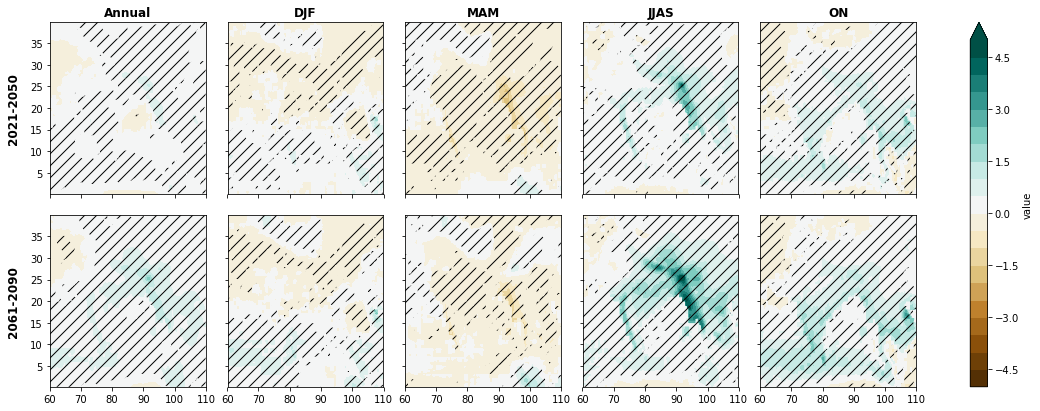

In [261]:
g = (ttest_ds
 .sel(stats='change', variable='pr', scen='rcp45')
 .value.plot
 .contourf(col='seas', row='tslice', cmap='BrBG', levels=np.arange(-5, 5.5, 0.5)))

for i, col in enumerate(g.axes):
    if i == 0:
        tslice = '2021-2050'
    else:
        tslice = '2061-2090'
    
    j = 0
    for ax, seas in zip(col, seasons):
        (sig_alpha
         .sel(seas=seas, variable='pr', scen='rcp45', tslice=tslice)
         .value.plot
         .contourf(hatches=['//'], alpha=0, add_colorbar=False,ax=ax))
        
        if i == 0:
            ax.set_title(seas, fontweight='bold')
            if j == 0:
                ax.set_ylabel(tslice, fontweight='bold')
        else:
            ax.set_title('')
            
        ax.set_xlabel('')
        ax.set_ylabel('')
        
        if j == 4:
            ax.texts[0].remove()
        
        
        j += 1
        

g.axes[0, 0].set_ylabel('2021-2050', fontweight='bold', fontsize=12, labelpad=10)
g.axes[1, 0].set_ylabel('2061-2090', fontweight='bold', fontsize=12, labelpad=10)

In [266]:
ttest_ds

<xarray.Dataset>
Dimensions:   (lat: 160, lon: 200, scen: 2, seas: 5, stats: 2, tslice: 2, variable: 4)
Coordinates:
  * stats     (stats) <U6 'change' 'pval'
  * tslice    (tslice) <U9 '2021-2050' '2061-2090'
  * scen      (scen) <U5 'rcp45' 'rcp85'
  * seas      (seas) <U6 'Annual' 'DJF' 'MAM' 'JJAS' 'ON'
  * variable  (variable) <U6 'pr' 'tas' 'tasmax' 'tasmin'
  * lat       (lat) float32 0.125 0.375 0.625 0.875 ... 39.375 39.625 39.875
  * lon       (lon) float32 60.125 60.375 60.625 ... 109.375 109.625 109.875
Data variables:
    value     (stats, tslice, scen, seas, variable, lat, lon) float64 0.1082 ... 3.367e-40

In [253]:
g.axes[0, 4].texts

[Text(1.02, 0.5, 'tslice = 2021-2050')]

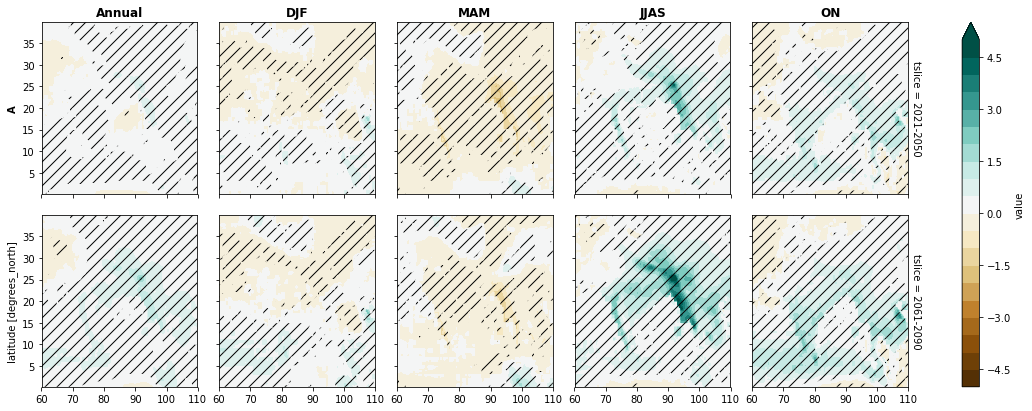

In [240]:
g.s

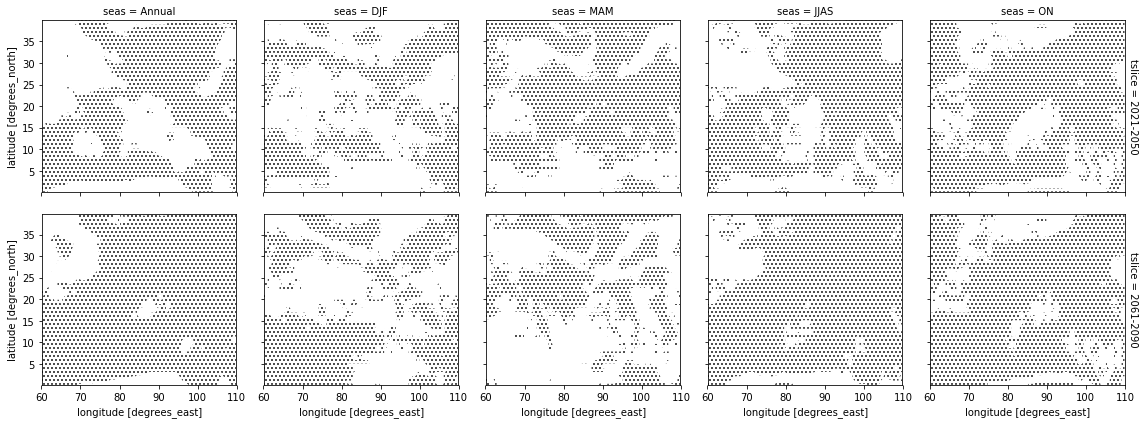

In [213]:
(sig_alpha
 .sel(variable='pr', scen='rcp45')
 .value.plot
 .contourf(hatches=['...'], alpha=0, col='seas', row='tslice', cmap='BrBG', add_colorbar=False))

In [207]:
(sig_alpha
 .sel(seas=seas, var=var, scen=scen, tslice=tslice)
 .plot.contourf(hatches=["...", "..."], alpha=0, ax=ax, add_colorbar=False))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8a23d147f0>,
      dtype=object)

In [77]:
change = calc_change()

In [78]:
change

<xarray.Dataset>
Dimensions:   (lat: 160, lon: 200, scen: 2, seas: 5, tslice: 2, variable: 4)
Coordinates:
  * lon       (lon) float32 60.125 60.375 60.625 ... 109.375 109.625 109.875
  * lat       (lat) float32 0.125 0.375 0.625 0.875 ... 39.375 39.625 39.875
  * variable  (variable) object 'pr' 'tas' 'tasmax' 'tasmin'
  * scen      (scen) object 'rcp45' 'rcp85'
  * seas      (seas) object 'Annual' 'DJF' 'MAM' 'JJAS' 'ON'
  * tslice    (tslice) object '2021-2050' '2061-2090'
Data variables:
    value     (tslice, seas, scen, variable, lat, lon) float32 0.10820961 ... 4.193771

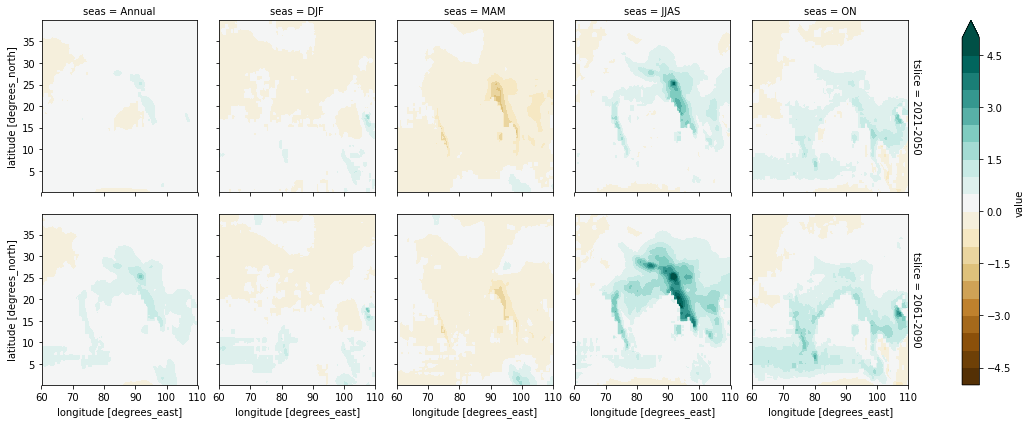

In [96]:
(change
 .sel(variable='pr', scen='rcp45')
 .value
 .plot
 .contourf(col='seas', row='tslice', cmap='BrBG', levels=np.arange(-5, 5.5, 0.5))
)

In [19]:
diff_scen = ttest_ds.sel(scen='rcp85') - ttest_ds.sel(scen='rcp45')

(12, 20)

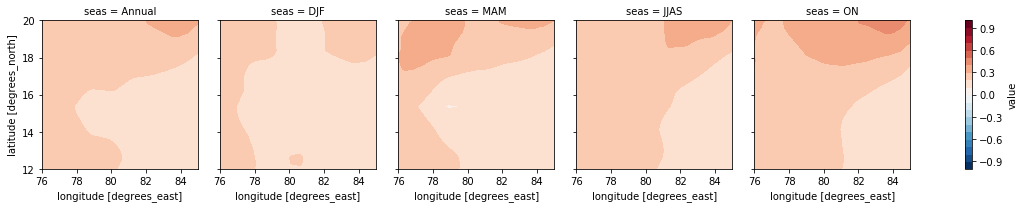

In [28]:
(diff_scen
 .sel(stats='change', variable='tasmin', tslice='2021-2050')
 .value
 .plot
 .contourf(col='seas',cmap='RdBu_r', levels=np.arange(-1, 1.1, 0.1))
)

plt.xlim(76, 85)
plt.ylim(12, 20)

In [20]:
diff_scen


<xarray.Dataset>
Dimensions:   (lat: 160, lon: 200, seas: 5, stats: 2, tslice: 2, variable: 4)
Coordinates:
  * stats     (stats) <U6 'change' 'pval'
  * tslice    (tslice) <U9 '2021-2050' '2061-2090'
  * seas      (seas) <U6 'Annual' 'DJF' 'MAM' 'JJAS' 'ON'
  * variable  (variable) <U6 'pr' 'tas' 'tasmax' 'tasmin'
  * lat       (lat) float32 0.125 0.375 0.625 0.875 ... 39.375 39.625 39.875
  * lon       (lon) float32 60.125 60.375 60.625 ... 109.375 109.625 109.875
Data variables:
    value     (stats, tslice, seas, variable, lat, lon) float64 0.1079 ... 3.196e-40